<a href="https://colab.research.google.com/github/saspav/data_engineer/blob/main/DZ_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Задача 1. Загрузите данные из файла data_dz01.csv в базу данных PostgreSQL, используя Python

In [1]:
# !pip install psycopg2

In [2]:
import os
import numpy as np
import pandas as pd
import psycopg2

__import__("warnings").filterwarnings('ignore')

# Параметры подключения к базе данных
params_psycopg = {'host': '84.201.158.108',
                  'port': 5432,
                  'database': 'test',
                  'user': 'test',
                  'password': 'test'
                  }


def create_table():
    """Создание таблицы в базе данных"""
    conn = psycopg2.connect(**params_psycopg)
    cursor = conn.cursor()
    query = 'CREATE TABLE IF NOT EXISTS pavlov (YearsExperience FLOAT, Salary FLOAT);'
    cursor.execute(query)
    conn.commit()
    cursor.close()
    conn.close()


def load_data():
    """Загрузка данных из файла в таблицу"""
    conn = psycopg2.connect(**params_psycopg)
    cursor = conn.cursor()

    # Проверяем наличие таблицы
    exists = False
    try:
        cursor.execute(f"SELECT EXISTS(SELECT 1 FROM information_schema.tables WHERE table_name = 'pavlov')")
        exists = cursor.fetchone()[0]
    except (Exception, psycopg2.Error) as error:
        print("Ошибка при проверке наличия таблицы:", error)

    if exists:
        print("Таблица 'pavlov' в БД существует.")
    else:
        # Чтение файла с помощью Pandas
        file = 'data_dz01.csv'
        if not os.access(file, os.F_OK):
            file = 'https://raw.githubusercontent.com/saspav/data_engineer/main/data_dz01.csv'
        df = pd.read_csv(file, sep=';')

        # Загрузка данных в базу данных
        for _, row in df.iterrows():
            insert_query = 'INSERT INTO pavlov (YearsExperience, Salary) VALUES (%s, %s);'
            cursor.execute(insert_query, (row.YearsExperience, row.Salary))
        conn.commit()

    cursor.close()
    conn.close()

In [3]:
# Создание таблицы
create_table()

# Загрузка данных
load_data()

Таблица 'pavlov' в БД существует.


### Задача 2. Загрузите данные в pandas dataframe и примените алгоритм ML (линейной регрессии).

In [4]:
import matplotlib.pyplot as plt

params_plt = {'font.size': 14,
              'axes.titlesize': 15,  # Размер шрифта главной подписи
              'axes.labelsize': 14,  # Размер шрифта подписей осей
              'xtick.labelsize': 12,  # Размер шрифта подписей тикетов оси X
              'ytick.labelsize': 12,  # Размер шрифта подписей тикетов оси Y

              }

plt.rcParams.update(params_plt)

In [5]:
def load_data():
    """Загрузка данных из базы данных в DataFrame"""
    conn = psycopg2.connect(**params_psycopg)
    data = pd.read_sql("SELECT * FROM pavlov", conn)
    conn.close()
    data.columns = ['YearsExperience', 'Salary']
    return data


# Загрузка данных из БД в DataFrame
df = load_data()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   YearsExperience  30 non-null     float64
 1   Salary           30 non-null     float64
dtypes: float64(2)
memory usage: 608.0 bytes


In [7]:
df.describe()

,YearsExperience,Salary
count,30.000000,30.000000
mean,5.313333,76003.000000
std,2.837888,27414.429785
min,1.100000,37731.000000
25%,3.200000,56720.750000
50%,4.700000,65237.000000
75%,7.700000,100544.750000
max,10.500000,122391.000000


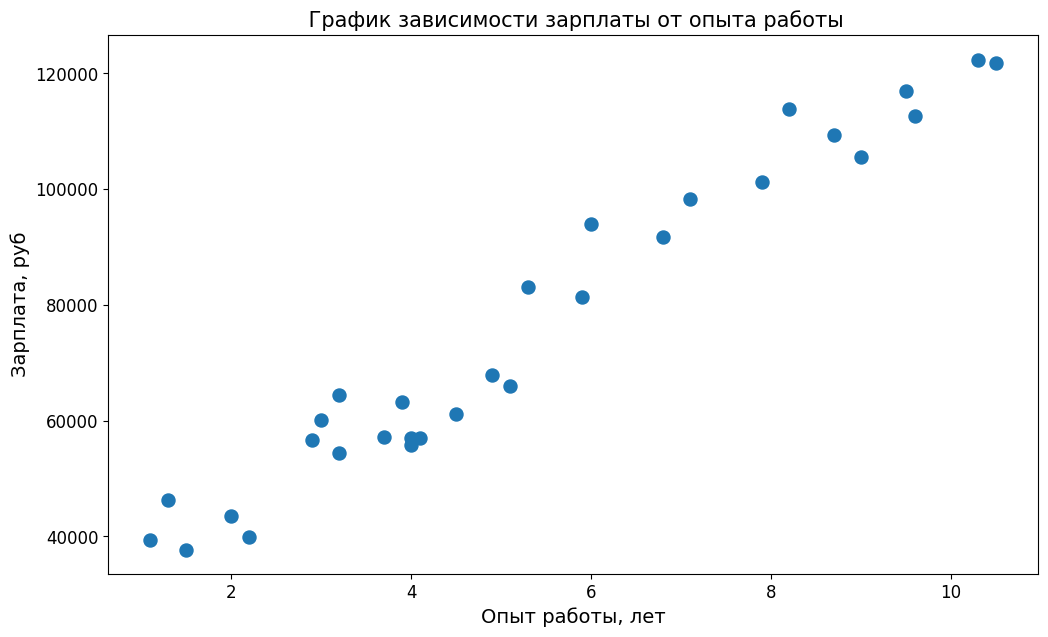

In [8]:
fig, ax = plt.subplots(figsize=(12, 7))
plt.scatter(df.YearsExperience,df.Salary, s=88)
plt.xlabel("Опыт работы, лет")
plt.ylabel("Зарплата, руб")
plt.title(" График зависимости зарплаты от опыта работы")
plt.show()

### Построение модели линейной регрессии

In [9]:
# Импорт необходимых функций из библиотеки sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [10]:
# Разделяем выборку на x,y
X, Y = df.drop(["Salary"], axis=1), df.Salary

In [11]:
# Разделения массива данных на тренировочную и тестовую.
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.13, random_state=13)

In [12]:
#Инициализируем и обучаем модель линейной регрессии
linear_model = LinearRegression()
linear_model.fit(x_train, y_train)
print("Коэффициенты линейной регрессии:")
print("Коэффициенты (coef): ", *linear_model.coef_.round(2))
print("Смещение (intercept): ", linear_model.intercept_.round(2))

Коэффициенты линейной регрессии:
Коэффициенты (coef):  9565.37
Смещение (intercept):  24949.94


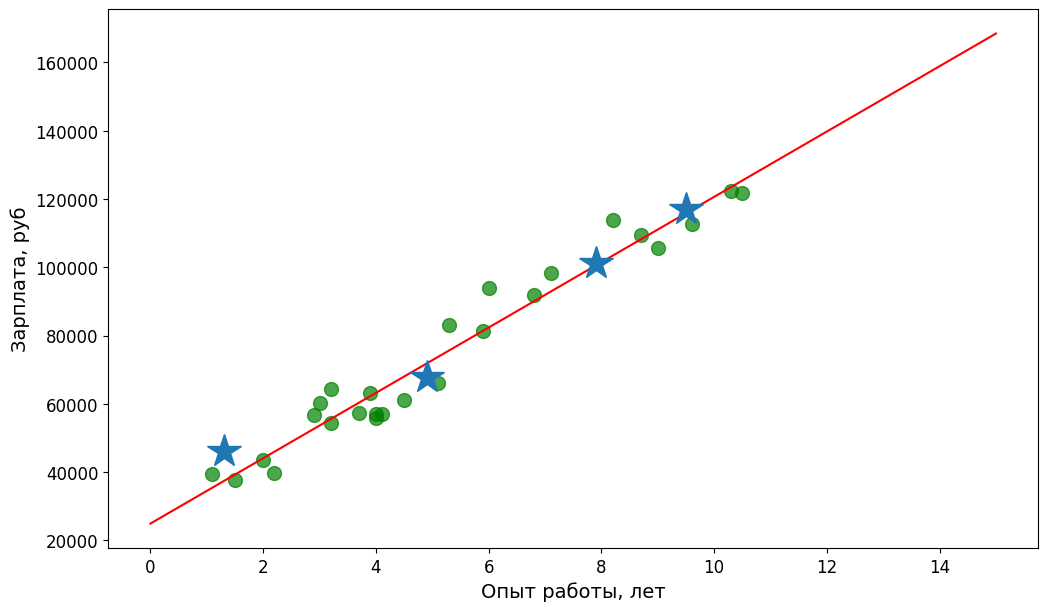

Точность линейной регрессии на трейне: 95.41%
Точность линейной регрессии на тесте: 96.91%


In [13]:
# Визуализируем полученный результат  и выведем точность регрессии
xfit = np.linspace(0, 15)
yfit = linear_model.predict(xfit[:, np.newaxis])
fig, ax = plt.subplots(figsize=(12, 7))
plt.plot(xfit, yfit, color= 'r')
plt.scatter(x_train, y_train, color= 'g', s=100, alpha=0.7)
plt.plot(x_test, y_test, '*', markersize=25)
plt.xlabel("Опыт работы, лет")
plt.ylabel("Зарплата, руб")
plt.show()
print(f'Точность линейной регрессии на трейне: {linear_model.score(x_train, y_train):.2%}')
print(f'Точность линейной регрессии на тесте: {linear_model.score(x_test, y_test):.2%}')

На тесте получился результат лучше трейна, просто удачно выбрались тестовые данные: 2 лежат на линии регресии, 2 других очень близко.

### У нас простая линейная регрессия вида: y = ax + b, то она не подвержена переобучению, т.к. можно обучить модель на всех данных

In [14]:
linear_model = LinearRegression()
linear_model.fit(X,Y)
print("Коэффициенты линейной регрессии:")
print("Коэффициенты (coef): ", *linear_model.coef_.round(2))
print("Смещение (intercept): ", linear_model.intercept_.round(2))

Коэффициенты линейной регрессии:
Коэффициенты (coef):  9449.96
Смещение (intercept):  25792.2


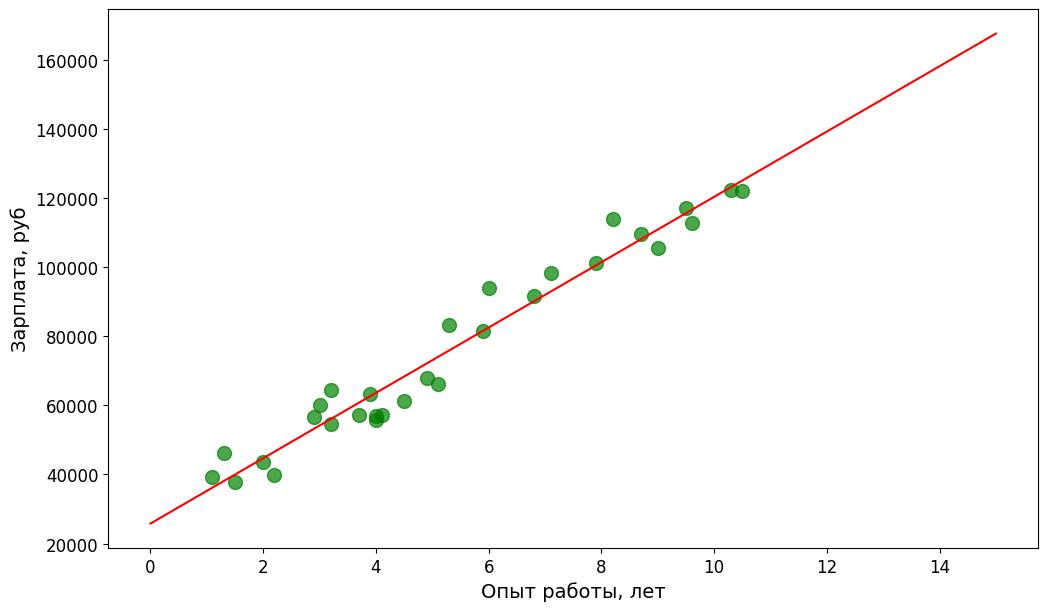

Точность линейной регрессии составила 95.70%


In [15]:
xfit = np.linspace(0, 15)
yfit = linear_model.predict(xfit[:, np.newaxis])
fig, ax = plt.subplots(figsize=(12, 7))
plt.plot(xfit, yfit, color= 'r')
plt.scatter(X, Y, color= 'g', s=100, alpha=0.7)
plt.xlabel("Опыт работы, лет")
plt.ylabel("Зарплата, руб")
plt.show()
print(f'Точность линейной регрессии составила {linear_model.score(X,Y):.2%}')

#### Интересный результат! Точность модели, обученной на всех данных, получилась хуже валидации, но точность на обучаущей выборке, стала на 3 десятых процента выше

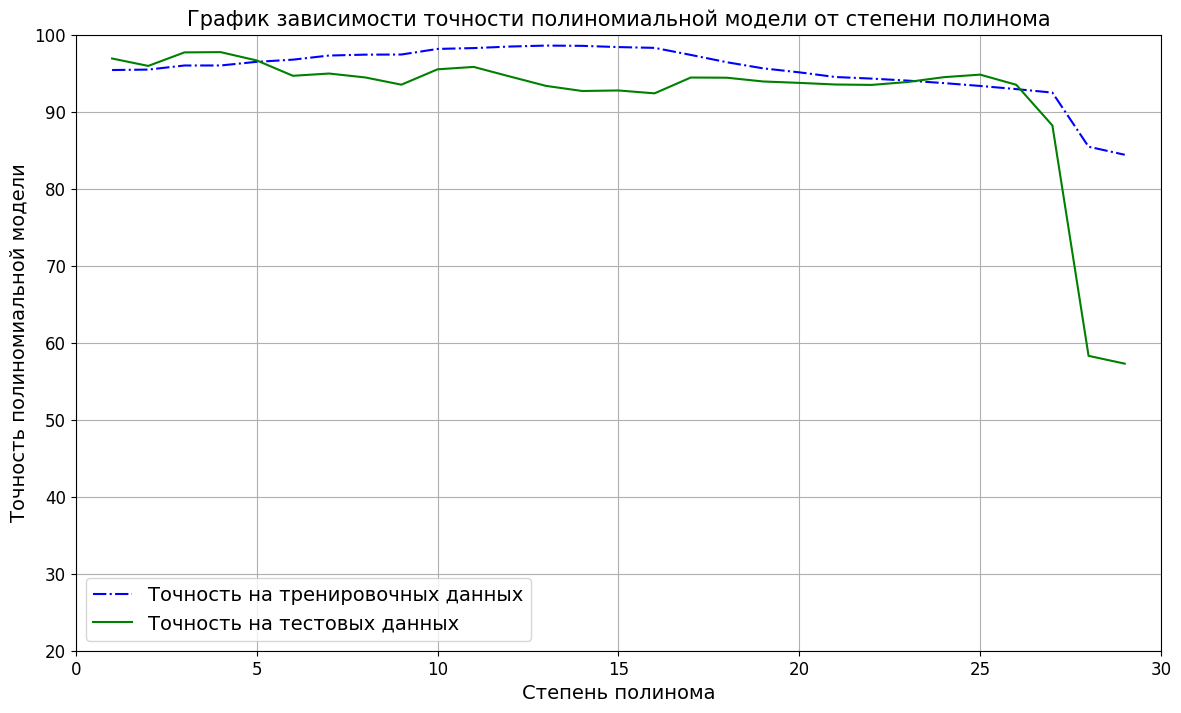

In [16]:
# Построим модель полимиальной регрессии

 # Импортируем необходимые библиотеки
from sklearn.preprocessing import PolynomialFeatures

# С помощью цикла переберем степени полинома от 1, 30 и выберем наилучший результата
degree = [i for i in range(1, 30)]
model_train, model_test = [], []
for d in degree:
    poly_model = PolynomialFeatures(degree=d)
    x_poly = poly_model.fit_transform(x_train)
    lin_reg = LinearRegression()
    lin_reg.fit(x_poly, y_train)
    model_train.append(lin_reg.score(x_poly, y_train)*100)
    model_test.append(lin_reg.score(poly_model.fit_transform(x_test), y_test)*100)


#Визуализируем полученный результат
plt.figure(figsize=(14,8))
plt.grid(True)
plt.plot(degree, model_train, color='blue', label= 'Точность на тренировочных данных', linestyle='-.')
plt.plot(degree, model_test, color='green', label= 'Точность на тестовых данных', linestyle='-')
plt.axis([0, 30, 20, 100])
# plt.yticks([ i for i in range(65, 76)])
# plt.xticks([ i for i in range(1, 21)])
plt.legend()
plt.xlabel('Степень полинома')
plt.ylabel('Точность полиномиальной модели')
plt.title('График зависимости точности полиномиальной модели от степени полинома')
plt.show()

In [17]:
for degree in range(1, 7):
    print(f'Точность модели при степени полинома: {degree}, '
          f'трейн = {model_train[degree-1]:.2f}%, тест={model_test[degree-1]:.2f}%')

Точность модели при степени полинома: 1, трейн = 95.41%, тест=96.91%
Точность модели при степени полинома: 2, трейн = 95.47%, тест=95.95%
Точность модели при степени полинома: 3, трейн = 96.00%, тест=97.70%
Точность модели при степени полинома: 4, трейн = 96.01%, тест=97.74%
Точность модели при степени полинома: 5, трейн = 96.48%, тест=96.66%
Точность модели при степени полинома: 6, трейн = 96.76%, тест=94.67%


#### Данных очень мало, чтобы выбрать наилучшую степень полиномиальной модели, возможно полином 3-4 степени...